In [1]:
## this is the phase 3 of the project

## first we will import the required functions from the utils file 
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sfm_utils import (
    load_gray_image,
    build_intrinsics_from_image_size,
    get_feature_extractor,   # this is the SIFT/ORB selector we wrote
)

# Dataset path (same as before)
DATASET_DIR = r"C:\UNI\Fall 2025 Senior\CV\Project\CV_Project_Group3\dataset2"


In [2]:
# Collect image filenames
# We already know images are 1.jpeg, 2.jpeg, ..., N.jpeg
N_IMAGES = 63
image_names = [f"{i}.jpeg" for i in range(1, N_IMAGES + 1)]

print(f"[INFO] Using {N_IMAGES} sequentially numbered images.")
print(image_names[:10])

# ---- Build K_iphone from FIRST image resolution ----
first_img = load_gray_image(DATASET_DIR, image_names[0])
h, w = first_img.shape[:2]
print("Working image size:", w, "x", h)

# iPhone EXIF info
f35 = 19.0               # FocalLengthIn35mmFilm from EXIF
sensor_width_35mm = 36.0 # mm, standard 35mm frame width

fx = fy = (f35 / sensor_width_35mm) * w
cx = w / 2.0
cy = h / 2.0

K = np.array([
    [fx, 0.0, cx],
    [0.0, fy, cy],
    [0.0, 0.0, 1.0]
], dtype=np.float64)

print("Intrinsic matrix K (iPhone-style) =\n", K)


[INFO] Using 63 sequentially numbered images.
['1.jpeg', '2.jpeg', '3.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '7.jpeg', '8.jpeg', '9.jpeg', '10.jpeg']
Working image size: 1200 x 1600
Intrinsic matrix K (iPhone-style) =
 [[633.33333333   0.         600.        ]
 [  0.         633.33333333 800.        ]
 [  0.           0.           1.        ]]


In [3]:
# Get feature extractor (SIFT preferred, ORB fallback)
feature, use_orb = get_feature_extractor()
print("[INFO] Using", "ORB" if use_orb else "SIFT", "for all images")

all_kps = {}
all_desc = {}

for idx, name in enumerate(image_names, start=1):
    gray = load_gray_image(DATASET_DIR, name)
    kps, desc = feature.detectAndCompute(gray, None)
    
    all_kps[idx] = kps
    all_desc[idx] = desc
    
    print(f"Image {idx:02d}: {name} -> {len(kps)} keypoints")

print("\n[INFO] Precomputed features for", len(all_kps), "images.")


[INFO] Using SIFT for all images
Image 01: 1.jpeg -> 11621 keypoints
Image 02: 2.jpeg -> 9735 keypoints
Image 03: 3.jpeg -> 9136 keypoints
Image 04: 4.jpeg -> 9247 keypoints
Image 05: 5.jpeg -> 8916 keypoints
Image 06: 6.jpeg -> 8144 keypoints
Image 07: 7.jpeg -> 7434 keypoints
Image 08: 8.jpeg -> 6182 keypoints
Image 09: 9.jpeg -> 6574 keypoints
Image 10: 10.jpeg -> 6566 keypoints
Image 11: 11.jpeg -> 6706 keypoints
Image 12: 12.jpeg -> 7409 keypoints
Image 13: 13.jpeg -> 8068 keypoints
Image 14: 14.jpeg -> 8062 keypoints
Image 15: 15.jpeg -> 7187 keypoints
Image 16: 16.jpeg -> 7186 keypoints
Image 17: 17.jpeg -> 7050 keypoints
Image 18: 18.jpeg -> 5864 keypoints
Image 19: 19.jpeg -> 5337 keypoints
Image 20: 20.jpeg -> 5094 keypoints
Image 21: 21.jpeg -> 4396 keypoints
Image 22: 22.jpeg -> 4499 keypoints
Image 23: 23.jpeg -> 3447 keypoints
Image 24: 24.jpeg -> 3129 keypoints
Image 25: 25.jpeg -> 3237 keypoints
Image 26: 26.jpeg -> 3164 keypoints
Image 27: 27.jpeg -> 3153 keypoints
Ima

In [4]:
# Camera poses: index -> (R, t)
# We will set cameras[1] and cameras[2] after two-view init.
cameras = {}

# 3D points: point_id -> 3D coordinate (x,y,z)
points3d = {}

# Observations: point_id -> list of (img_idx, kp_idx)
observations = {}

# Reverse map: (img_idx, kp_idx) -> point_id
keypoint_to_point = {}

print("[INFO] SfM containers initialized.")


[INFO] SfM containers initialized.


[INFO] 1↔2: 2881 good matches


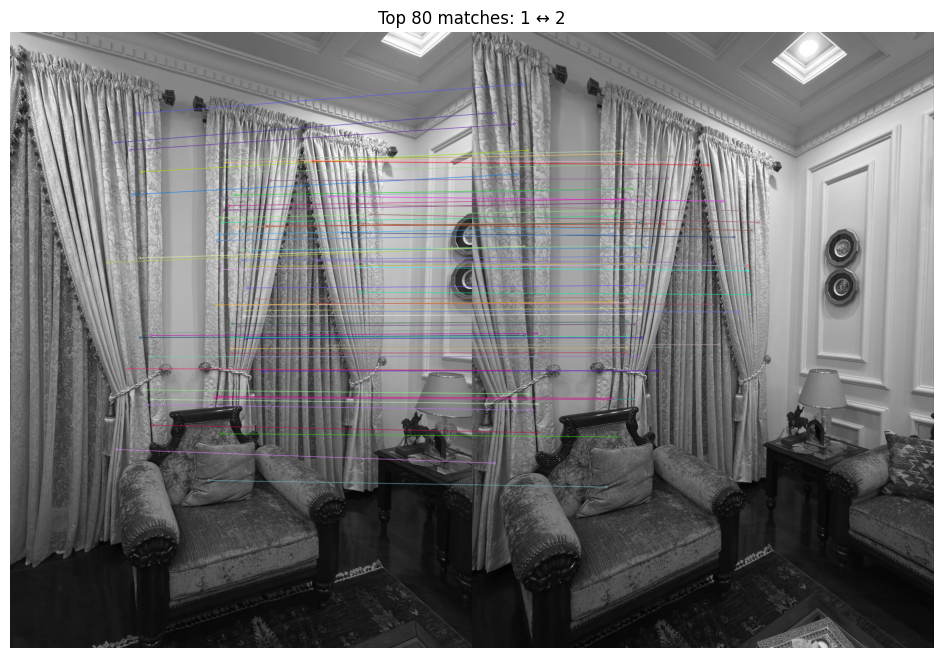

pts1 shape: (2881, 2) pts2 shape: (2881, 2)
[INFO] E inliers: 2642 / 2881
E =
 [[ 5.78505914e-03 -1.14982401e-01  3.56462905e-02]
 [-1.84108196e-02 -1.36045963e-04 -7.05937134e-01]
 [-2.92628013e-02  6.97057925e-01  6.53042698e-03]]
Recovered R_2 =
 [[ 9.82045407e-01 -9.00680219e-03 -1.88429551e-01]
 [ 9.08863636e-03  9.99958605e-01 -4.29740214e-04]
 [ 1.88425621e-01 -1.29054326e-03  9.82086615e-01]]
Recovered t_2 =
 [[-0.98536787]
 [-0.05125985]
 [-0.16255025]]


In [5]:
## recovering the pose bw img1 and img2 -> this is the same as phase 2 (copy and pasted)

if use_orb:
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
else:
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

def match_desc(desc1, desc2, ratio_thresh=0.75):
    """KNN match + Lowe's ratio test."""
    knn = bf.knnMatch(desc1, desc2, k=2)
    good = []
    for m, n in knn:
        if m.distance < ratio_thresh * n.distance:
            good.append(m)
    return good

# --- Two-view init: image 1 & 2 ---
i1, i2 = 1, 2
kps1, desc1 = all_kps[i1], all_desc[i1]
kps2, desc2 = all_kps[i2], all_desc[i2]

good_matches = match_desc(desc1, desc2, ratio_thresh=0.75)
print(f"[INFO] 1↔2: {len(good_matches)} good matches")

# Visualize top 80 matches (optional sanity check)
good_sorted = sorted(good_matches, key=lambda m: m.distance)[:80]

img1_vis = load_gray_image(DATASET_DIR, image_names[i1-1])
img2_vis = load_gray_image(DATASET_DIR, image_names[i2-1])

vis12 = cv2.drawMatches(
    img1_vis, kps1,
    img2_vis, kps2,
    good_sorted, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(16, 8))
plt.imshow(vis12, cmap='gray')
plt.title("Top 80 matches: 1 ↔ 2")
plt.axis('off')
plt.show()

# --- Build matched point arrays ---
pts1 = np.array([kps1[m.queryIdx].pt for m in good_matches], dtype=np.float64)
pts2 = np.array([kps2[m.trainIdx].pt for m in good_matches], dtype=np.float64)

print("pts1 shape:", pts1.shape, "pts2 shape:", pts2.shape)

# --- Essential matrix with RANSAC ---
E, mask_E = cv2.findEssentialMat(
    pts1, pts2,
    K,
    method=cv2.RANSAC,
    prob=0.999,
    threshold=1.0
)
inliers_E = mask_E.ravel() == 1
print(f"[INFO] E inliers: {np.sum(inliers_E)} / {len(mask_E)}")
print("E =\n", E)

pts1_in = pts1[inliers_E]
pts2_in = pts2[inliers_E]

# --- Recover pose (R, t) ---
_, R_2, t_2, mask_pose = cv2.recoverPose(E, pts1_in, pts2_in, K)
print("Recovered R_2 =\n", R_2)
print("Recovered t_2 =\n", t_2)


In [6]:
# --- Projection matrices for cams 1 & 2 ---
P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])
P2 = K @ np.hstack([R_2, t_2])

# Prepare for triangulation: 2×N
pts1_T = pts1_in.T
pts2_T = pts2_in.T

# Triangulate
points_4d = cv2.triangulatePoints(P1, P2, pts1_T, pts2_T)  # 4×N
points_3d = (points_4d[:3] / points_4d[3]).T               # N×3

print("Triangulated points_3d:", points_3d.shape)

# --- Cheirality check: points in front of both cameras ---
X = points_3d.T  # 3×N

# camera 1: [I | 0]
X_cam1 = X
z1 = X_cam1[2, :]

# camera 2: [R_2 | t_2]
X_cam2 = R_2 @ X + t_2
z2 = X_cam2[2, :]

in_front = (z1 > 0) & (z2 > 0)
print("Points in front of both cameras:", np.sum(in_front), "/", X.shape[1])

points_3d_valid = points_3d[in_front]
print("Valid 3D points after cheirality:", points_3d_valid.shape)


Triangulated points_3d: (2642, 3)
Points in front of both cameras: 2642 / 2642
Valid 3D points after cheirality: (2642, 3)


In [7]:
# We'll create a global incremental point_id counter
next_point_id = 0

# Keep only the matches that survived both E RANSAC and cheirality
good_matches_inliers = [m for m, keep in zip(good_matches, inliers_E) if keep]
# Now also apply cheirality (same in_front mask)
good_matches_final = [m for m, keep in zip(good_matches_inliers, in_front) if keep]

print("Final matches used for map points:", len(good_matches_final))
print("points_3d_valid:", points_3d_valid.shape)

assert len(good_matches_final) == points_3d_valid.shape[0]

# Initialize camera poses
cameras[1] = (np.eye(3), np.zeros((3, 1)))  # [I|0]
cameras[2] = (R_2, t_2)

# Fill points3d, observations, keypoint_to_point
for X, m in zip(points_3d_valid, good_matches_final):
    pid = next_point_id
    next_point_id += 1

    # Store 3D point
    points3d[pid] = X

    # Keypoint indices in image 1 and 2
    kp_idx1 = m.queryIdx
    kp_idx2 = m.trainIdx

    # Observations: which image & which keypoint index see this point
    observations[pid] = [(1, kp_idx1), (2, kp_idx2)]

    # Reverse map: kp -> point id
    keypoint_to_point[(1, kp_idx1)] = pid
    keypoint_to_point[(2, kp_idx2)] = pid

print("[INFO] Two-view map initialized:")
print("  Cameras:", list(cameras.keys()))
print("  Num 3D points:", len(points3d))
print("  Example point id 0:", points3d[0] if len(points3d) > 0 else "None")


Final matches used for map points: 2642
points_3d_valid: (2642, 3)
[INFO] Two-view map initialized:
  Cameras: [1, 2]
  Num 3D points: 2642
  Example point id 0: [-10.27603096 -17.53531489  17.77191352]


PHASE 3 STARTS HERE. NOW WE HAVE BOTH CAM[0] AND CAM[1] CALIBRATED

In [8]:
## we need a helper to build 2d -> 3d correspondences for PnP
def build_pnp_correspondences(img_prev, img_curr, matches):
    """
    img_prev: index of previous image
    img_curr: index of current image
    matches: list of cv2.DMatch (prev->curr matches)

    Returns objectPoints (Nx3), imagePoints (Nx2), and matches_pnp (filtered matches)
    """
    obj_pts = []
    img_pts = []
    matches_pnp = []

    for m in matches:
        kp_prev = m.queryIdx  # keypoint in prev image
        key = (img_prev, kp_prev)

        # Does this keypoint correspond to a 3D point already?
        if key in keypoint_to_point:
            pid = keypoint_to_point[key]
            obj_pts.append(points3d[pid])                     # 3D point
            img_pts.append(all_kps[img_curr][m.trainIdx].pt)  # 2D point in new image
            matches_pnp.append(m)

    if len(obj_pts) == 0:
        return None, None, None

    return np.array(obj_pts, dtype=np.float64), \
           np.array(img_pts, dtype=np.float64), \
           matches_pnp


In [9]:
def triangulate_new_points(img_prev, img_curr, matches, R_prev, t_prev, R_curr, t_curr):
    """
    Triangulate new 3D points from matches between img_prev and img_curr.
    Only triangulates points that are not already in the map.
    """
    P_prev = K @ np.hstack([R_prev, t_prev])
    P_curr = K @ np.hstack([R_curr, t_curr])

    new_points = []
    new_matches = []

    pts_prev = []
    pts_curr = []

    for m in matches:
        # If this match already corresponds to a 3D point, skip
        if (img_prev, m.queryIdx) in keypoint_to_point:
            continue

        # Otherwise, prepare for triangulation
        pts_prev.append(all_kps[img_prev][m.queryIdx].pt)
        pts_curr.append(all_kps[img_curr][m.trainIdx].pt)
        new_matches.append(m)

    if len(pts_prev) < 5:
        return []

    pts_prev = np.array(pts_prev).T
    pts_curr = np.array(pts_curr).T

    pts_4d = cv2.triangulatePoints(P_prev, P_curr, pts_prev, pts_curr)
    pts_3d = (pts_4d[:3] / pts_4d[3]).T

    return list(zip(pts_3d, new_matches))


In [10]:
# BFMatcher for all image matching
if use_orb:
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
else:
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

def match_two_images(desc1, desc2):
    knn = bf.knnMatch(desc1, desc2, k=2)
    good = []
    for m, n in knn:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    return good

# Start incremental SfM from image 3 onward
for i in range(3, N_IMAGES + 1):

    print(f"\n[INFO] === Adding image {i} ===")

    prev = i - 1

    # Step 1 — match features prev ↔ i
    matches = match_two_images(all_desc[prev], all_desc[i])
    print(f"Matches between {prev} and {i}: {len(matches)}")

    # Step 2 — build 2D→3D correspondences for PnP
    obj_pts, img_pts, matches_pnp = build_pnp_correspondences(prev, i, matches)

    if obj_pts is None or len(obj_pts) < 6:
        print(f"[WARN] Not enough 2D-3D correspondences for image {i}. Skipping.")
        continue

    # Step 3 — Solve PnP
    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        objectPoints=obj_pts,
        imagePoints=img_pts,
        cameraMatrix=K,
        distCoeffs=None,
        reprojectionError=3.0,
        flags=cv2.SOLVEPNP_ITERATIVE
    )

    if not success:
        print(f"[ERROR] PnP failed for image {i}")
        continue

    R_i, _ = cv2.Rodrigues(rvec)
    t_i = tvec.reshape(3,1)

    cameras[i] = (R_i, t_i)
    print(f"[INFO] Camera {i} pose estimated. Inliers:", len(inliers))

    # Step 4 — triangulate new points with prev ↔ i
    R_prev, t_prev = cameras[prev]
    new_pts = triangulate_new_points(prev, i, matches, R_prev, t_prev, R_i, t_i)

    print(f"[INFO] Triangulated {len(new_pts)} new points.")

    # Step 5 — add new points to the map
    global next_point_id

    for (X, m) in new_pts:
        pid = next_point_id
        next_point_id += 1

        points3d[pid] = X
        observations[pid] = [(prev, m.queryIdx), (i, m.trainIdx)]

        keypoint_to_point[(prev, m.queryIdx)] = pid
        keypoint_to_point[(i, m.trainIdx)] = pid

    print(f"[INFO] Total 3D points so far: {len(points3d)}")



[INFO] === Adding image 3 ===
Matches between 2 and 3: 1617
[INFO] Camera 3 pose estimated. Inliers: 152
[INFO] Triangulated 928 new points.
[INFO] Total 3D points so far: 3570

[INFO] === Adding image 4 ===
Matches between 3 and 4: 1781
[INFO] Camera 4 pose estimated. Inliers: 45
[INFO] Triangulated 1495 new points.
[INFO] Total 3D points so far: 5065

[INFO] === Adding image 5 ===
Matches between 4 and 5: 2887
[INFO] Camera 5 pose estimated. Inliers: 173
[INFO] Triangulated 2193 new points.
[INFO] Total 3D points so far: 7258

[INFO] === Adding image 6 ===
Matches between 5 and 6: 2906
[INFO] Camera 6 pose estimated. Inliers: 347
[INFO] Triangulated 1844 new points.
[INFO] Total 3D points so far: 9102

[INFO] === Adding image 7 ===
Matches between 6 and 7: 3096
[INFO] Camera 7 pose estimated. Inliers: 170
[INFO] Triangulated 2180 new points.
[INFO] Total 3D points so far: 11282

[INFO] === Adding image 8 ===
Matches between 7 and 8: 2523
[INFO] Camera 8 pose estimated. Inliers: 345


In [11]:
# Collect all camera centers
cam_indices = sorted(cameras.keys())
cam_centers = []

for i in cam_indices:
    R_i, t_i = cameras[i]
    C_i = -R_i.T @ t_i  # camera center in world coords
    cam_centers.append(C_i.reshape(3))

cam_centers = np.array(cam_centers)  # shape (num_cams, 3)

# Collect all 3D points into a single array
all_points = np.array(list(points3d.values()))
print("Num cameras:", cam_centers.shape[0])
print("Num 3D points:", all_points.shape[0])


Num cameras: 63
Num 3D points: 82976


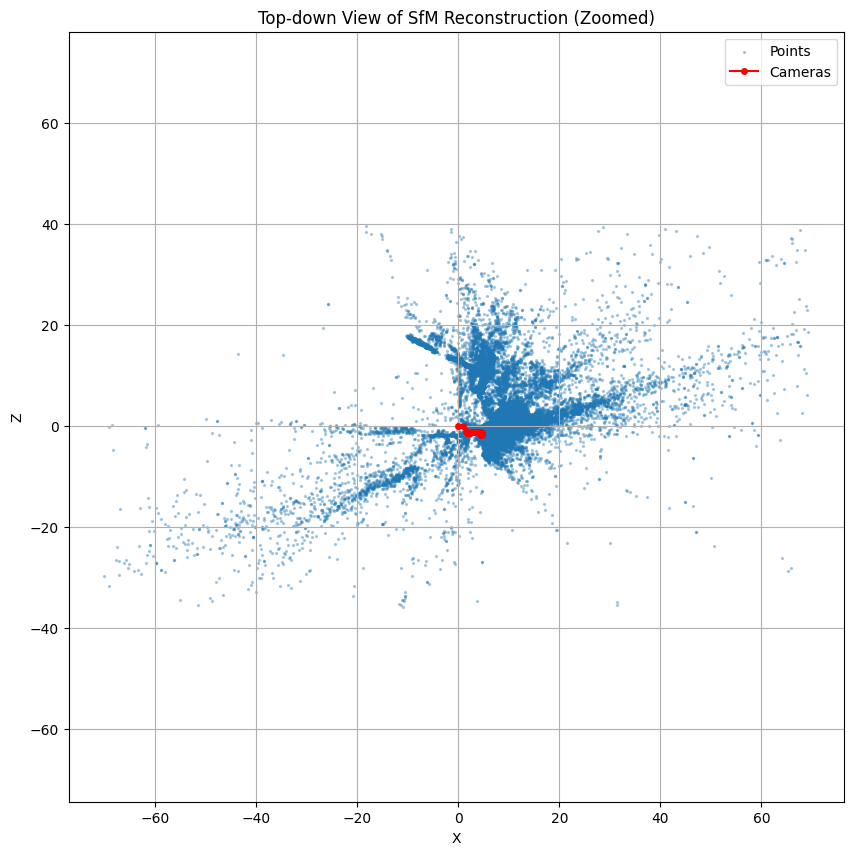

In [12]:
# -------------------------------------------------------
# 1. Filter out extreme outliers (keep central 99%)
# -------------------------------------------------------

low = np.percentile(all_points, 0.5, axis=0)
high = np.percentile(all_points, 99.5, axis=0)

mask = np.all((all_points >= low) & (all_points <= high), axis=1)
filtered_points = all_points[mask]

# -------------------------------------------------------
# 2D top-down view (X vs Z)
# -------------------------------------------------------

plt.figure(figsize=(10, 10))

plt.scatter(filtered_points[:, 0],
            filtered_points[:, 2],
            s=2, alpha=0.3, label="Points")

plt.plot(cam_centers[:, 0],
         cam_centers[:, 2],
         '-o', markersize=4, color='red', label='Cameras')

plt.xlabel("X")
plt.ylabel("Z")
plt.title("Top-down View of SfM Reconstruction (Zoomed)")
plt.legend()
plt.grid(True)
plt.axis('equal')     # keeps scale consistent

plt.show()


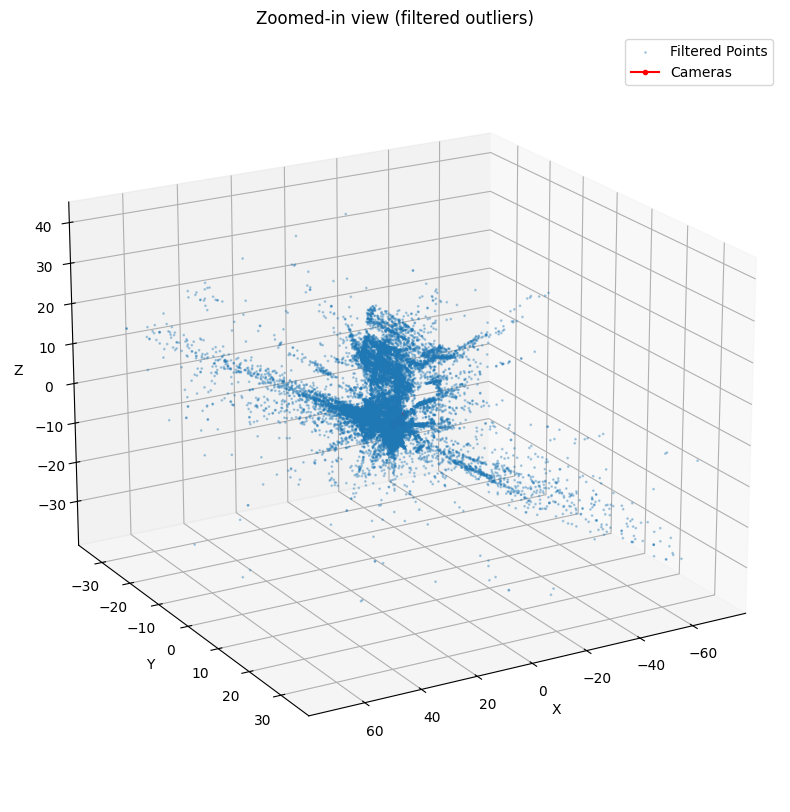

In [13]:
def zoom_point_cloud(all_points, cam_centers, percentile=99):
    import numpy as np
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt

    # Compute bounds excluding extreme outliers
    low = np.percentile(all_points, (100-percentile)/2, axis=0)
    high = np.percentile(all_points, 100 - (100-percentile)/2, axis=0)

    mask = np.all((all_points >= low) & (all_points <= high), axis=1)
    filtered = all_points[mask]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(filtered[:,0], filtered[:,1], filtered[:,2],
               s=1, alpha=0.3, label="Filtered Points")

    ax.plot(cam_centers[:,0], cam_centers[:,1], cam_centers[:,2],
            "-o", c="red", markersize=3, label="Cameras")

    ax.set_title("Zoomed-in view (filtered outliers)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    ax.view_init(elev=20, azim=60)
    plt.show()

zoom_point_cloud(all_points, cam_centers)


In [14]:
## these look ass so lets try and refine

In [15]:
import random
from collections import defaultdict
import numpy as np
from scipy.optimize import least_squares

# 1) camera index mapping
cam_indices = sorted(cameras.keys())
cam_to_ba_idx = {cam_idx: i for i, cam_idx in enumerate(cam_indices)}
num_cams = len(cam_indices)
print("Number of cameras:", num_cams)

# 2) build per-point observation count
point_obs_count = {pid: len(obs) for pid, obs in observations.items()}

# 3) choose subset of points for BA
#    - prefer points with more observations
#    - limit total for tractable optimization (e.g. 8000–10000)
sorted_pids = sorted(point_obs_count.keys(), key=lambda pid: -point_obs_count[pid])
MAX_POINTS_BA = 8000
ba_point_ids = sorted_pids[:MAX_POINTS_BA]
num_points = len(ba_point_ids)
print("Number of points used in BA:", num_points)

# map point id -> local BA index
pid_to_ba_idx = {pid: i for i, pid in enumerate(ba_point_ids)}

# 4) collect all observations for these points
# each obs: (camera_local_idx, point_local_idx, measured_x, measured_y)
ba_observations = []

for pid in ba_point_ids:
    X = points3d[pid]
    for (img_idx, kp_idx) in observations[pid]:
        if img_idx not in cam_to_ba_idx:
            continue
        cam_local = cam_to_ba_idx[img_idx]
        u, v = all_kps[img_idx][kp_idx].pt
        pt_local = pid_to_ba_idx[pid]
        ba_observations.append((cam_local, pt_local, u, v))

print("Number of BA observations:", len(ba_observations))


Number of cameras: 63
Number of points used in BA: 8000
Number of BA observations: 16000


In [16]:
def rt_to_params(R, t):
    rvec, _ = cv2.Rodrigues(R)
    return np.hstack([rvec.flatten(), t.flatten()])

def params_to_rt(p):
    rvec = p[:3].reshape(3, 1)
    t = p[3:].reshape(3, 1)
    R, _ = cv2.Rodrigues(rvec)
    return R, t

# initial parameter vector
cam_params_init = np.zeros((num_cams, 6))
for cam_idx, ba_idx in cam_to_ba_idx.items():
    R_i, t_i = cameras[cam_idx]
    cam_params_init[ba_idx] = rt_to_params(R_i, t_i)

point_params_init = np.zeros((num_points, 3))
for pid, pidx in pid_to_ba_idx.items():
    point_params_init[pidx] = points3d[pid]

print("cam_params_init shape:", cam_params_init.shape)
print("point_params_init shape:", point_params_init.shape)


cam_params_init shape: (63, 6)
point_params_init shape: (8000, 3)


In [17]:
def pack_params(cam_params, point_params):
    return np.hstack([cam_params.ravel(), point_params.ravel()])

def unpack_params(x):
    cam_flat = x[:num_cams * 6]
    pts_flat = x[num_cams * 6:]
    cam_params = cam_flat.reshape((num_cams, 6))
    point_params = pts_flat.reshape((num_points, 3))
    return cam_params, point_params

x0 = pack_params(cam_params_init, point_params_init)
print("Total BA parameters:", x0.size)


Total BA parameters: 24378


In [18]:
def project_point(K, cam_param, point_3d):
    R, t = params_to_rt(cam_param)
    X = point_3d.reshape(3, 1)
    x_cam = R @ X + t  # 3x1

    # avoid division by zero
    z = x_cam[2, 0] + 1e-8
    u = K[0, 0] * x_cam[0, 0] / z + K[0, 2]
    v = K[1, 1] * x_cam[1, 0] / z + K[1, 2]
    return u, v

def ba_residuals(x, K, ba_observations):
    cam_params, point_params = unpack_params(x)
    residuals = []

    for cam_idx, pt_idx, u_meas, v_meas in ba_observations:
        cam_p = cam_params[cam_idx]
        X = point_params[pt_idx]
        u_pred, v_pred = project_point(K, cam_p, X)
        residuals.append(u_meas - u_pred)
        residuals.append(v_meas - v_pred)

    return np.array(residuals)


In [37]:
import numpy as np
from scipy.optimize import least_squares
from scipy.sparse import coo_matrix

# --- 1. PREPARE DATA ---
print("[INFO] Preparing data structures...")
ba_observations_arr = np.array(ba_observations)

# Extract indices
cam_indices = ba_observations_arr[:, 0].astype(int)
point_indices = ba_observations_arr[:, 1].astype(int)

num_cams = np.max(cam_indices) + 1
num_points = np.max(point_indices) + 1

# Calculate params per camera
total_params = x0.size
points_params_total = num_points * 3
camera_params_total = total_params - points_params_total
params_per_cam = camera_params_total // num_cams

print(f"[INFO] Structure: {num_cams} cams, {num_points} points, {params_per_cam} params/cam.")

# --- 2. MEMORY-EFFICIENT SPARSITY FUNCTION (COO) ---
def build_sparsity_coo(n_cams, n_pts, c_idxs, p_idxs, p_per_cam):
    n_obs = c_idxs.size
    m = n_obs * 2
    n = n_cams * p_per_cam + n_pts * 3
    
    # We will collect all indices in lists, then merge them at the end
    # This avoids the "fancy indexing" memory spike
    rows_list = []
    cols_list = []
    
    # Pre-calculate common row indices for observations
    # obs_rows_x = [0, 2, 4, ...]
    # obs_rows_y = [1, 3, 5, ...]
    obs_rows_x = np.arange(0, m, 2)
    obs_rows_y = np.arange(1, m, 2)
    
    # --- A. CAMERA PARAMETERS ---
    for s in range(p_per_cam):
        # The column index for parameter 's' of the specific camera
        col_indices = c_idxs * p_per_cam + s
        
        # Add connections for X residuals
        rows_list.append(obs_rows_x)
        cols_list.append(col_indices)
        
        # Add connections for Y residuals
        rows_list.append(obs_rows_y)
        cols_list.append(col_indices)

    # --- B. POINT PARAMETERS ---
    point_offset = n_cams * p_per_cam
    for s in range(3):
        # The column index for parameter 's' of the specific point
        col_indices = point_offset + p_idxs * 3 + s
        
        rows_list.append(obs_rows_x)
        cols_list.append(col_indices)
        
        rows_list.append(obs_rows_y)
        cols_list.append(col_indices)

    # Merge all indices
    rows = np.concatenate(rows_list)
    cols = np.concatenate(cols_list)
    data = np.ones(rows.size, dtype=int)
    
    # Create the matrix in one shot
    matrix = coo_matrix((data, (rows, cols)), shape=(m, n))
    
    return matrix

# --- 3. BUILD MATRIX ---
print("[INFO] Building sparsity matrix (COO mode)...")
A = build_sparsity_coo(num_cams, num_points, cam_indices, point_indices, params_per_cam)

[INFO] Preparing data structures...
[INFO] Structure: 6 cams, 8000 points, 63 params/cam.
[INFO] Building sparsity matrix (COO mode)...


In [21]:
import numpy as np
from scipy.optimize import least_squares

# --- 1. REDEFINE UNPACKER TO BE ROBUST ---
# We overwrite your existing function with one that calculates num_points dynamically
def unpack_params(x):
    # We rely on the global 'num_cams' being correct, but we calculate points from the remainder
    # Assuming 6 parameters per camera (Rotation + Translation)
    params_per_cam = 6 
    cam_split_idx = num_cams * params_per_cam
    
    cam_flat = x[:cam_split_idx]
    pts_flat = x[cam_split_idx:]
    
    # DYNAMIC CALCULATION:
    # Instead of forcing shape (num_points, 3), we deduce it.
    actual_num_points = pts_flat.size // 3
    
    cam_params = cam_flat.reshape((num_cams, params_per_cam))
    point_params = pts_flat.reshape((actual_num_points, 3))
    
    return cam_params, point_params

# --- 2. ENSURE NUM_CAMS IS CORRECT ---
# Recalculate camera count from data to be safe
ba_observations_arr = np.array(ba_observations)
cam_indices = ba_observations_arr[:, 0].astype(int)
num_cams = np.max(cam_indices) + 1

print(f"[INFO] Using {num_cams} cameras.")
print("[INFO] unpack_params updated to handle point count dynamically.")

# --- 3. RUN OPTIMIZATION ---
# Ensure 'A' (the COO sparsity matrix) is still defined from the previous step!
print("[INFO] Starting Bundle Adjustment...")

result = least_squares(
    ba_residuals,
    x0,
    jac_sparsity=A,       # Uses the COO matrix we built earlier
    args=(K, ba_observations),
    verbose=2,
    x_scale='jac',
    ftol=1e-4,
    xtol=1e-4,
    gtol=1e-4,
    loss='linear',
    max_nfev=50,          # Limit iterations
    method='trf'
)

print("[INFO] Done.")
print(f"Final Cost: {result.cost}")

[INFO] Using 6 cameras.
[INFO] unpack_params updated to handle point count dynamically.
[INFO] Starting Bundle Adjustment...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.7286e+11                                    1.16e+16    
       1              3         3.0138e+10      5.43e+11       2.99e+04       1.66e+12    
       2             11         3.0138e+10      0.00e+00       0.00e+00       1.66e+12    
`xtol` termination condition is satisfied.
Function evaluations 11, initial cost 5.7286e+11, final cost 3.0138e+10, first-order optimality 1.66e+12.
[INFO] Done.
Final Cost: 30138238135.430717


[INFO] Plotting 8114 points.
[INFO] Filtered 812 outliers.


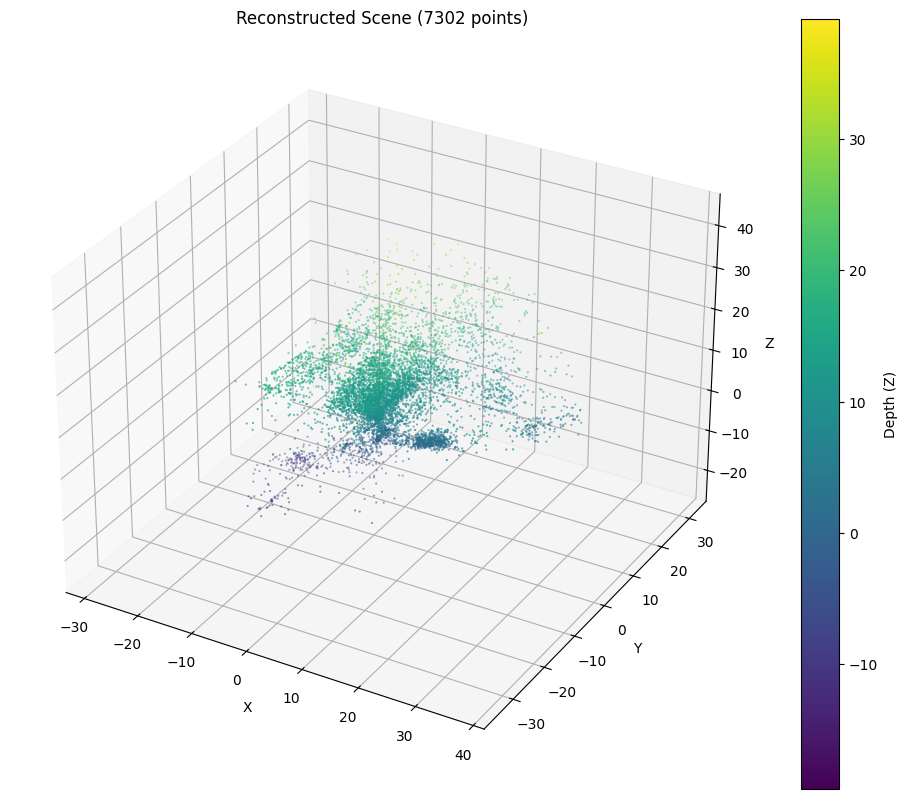

In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# --- 1. ROBUST DATA EXTRACTION ---
# We calculate the split point based on the known camera count
# Assumes params_per_cam is 6 (Rotation + Translation) based on your previous errors
params_per_cam = 6 
cam_params_end = num_cams * params_per_cam

# Extract the part of the array that belongs to points
points_flat = result.x[cam_params_end:]

# Dynamically reshape: (Whatever_Length_Remains, 3)
points_3d = points_flat.reshape((-1, 3))

print(f"[INFO] Plotting {points_3d.shape[0]} points.")

# --- 2. REMOVE OUTLIERS FOR BETTER VIEWING ---
# Bundle Adjustment can throw some points very far away (outliers).
# We filter points that are too far from the median to keep the plot readable.
center = np.median(points_3d, axis=0)
distances = np.linalg.norm(points_3d - center, axis=1)
# Keep only points within the 90th percentile of distance
mask = distances < np.percentile(distances, 90) 
points_clean = points_3d[mask]

print(f"[INFO] Filtered {len(points_3d) - len(points_clean)} outliers.")

# --- 3. PLOT ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the points
# c=points_clean[:, 2] colors them by depth (Z)
scatter = ax.scatter(
    points_clean[:, 0], 
    points_clean[:, 1], 
    points_clean[:, 2], 
    s=1,                   # Small marker size
    c=points_clean[:, 2],  # Color by depth
    cmap='viridis',
    marker='.'
)

# Formatting
ax.set_title(f"Reconstructed Scene ({len(points_clean)} points)")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Force equal aspect ratio (cubic box)
# This prevents the "pancake" effect where the Z-axis looks flattened
all_limits = np.concatenate([points_clean[:,0], points_clean[:,1], points_clean[:,2]])
limit_range = np.ptp(all_limits) / 2
mid_x, mid_y, mid_z = np.mean(points_clean[:,0]), np.mean(points_clean[:,1]), np.mean(points_clean[:,2])

ax.set_xlim(mid_x - limit_range, mid_x + limit_range)
ax.set_ylim(mid_y - limit_range, mid_y + limit_range)
ax.set_zlim(mid_z - limit_range, mid_z + limit_range)

plt.colorbar(scatter, label='Depth (Z)')

plt.show()

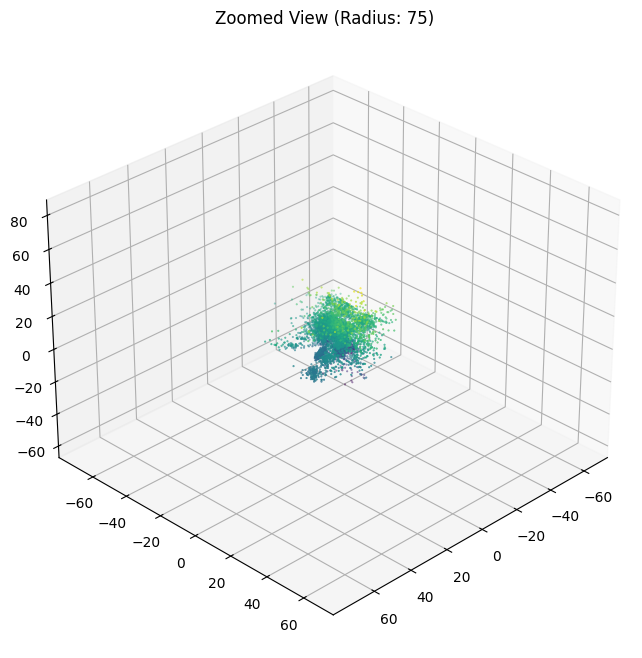

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. CONFIGURATION ---
ZOOM_RADIUS = 75  # <--- LOWER this number to zoom in MORE
                   #      HIGHER this number to zoom out

# --- 2. EXTRACT & CENTER ---
# Robust extraction
params_per_cam = 6 
cam_params_end = num_cams * params_per_cam
points_3d = result.x[cam_params_end:].reshape((-1, 3))

# Calculate the center of the cloud (using median to ignore outliers)
center = np.median(points_3d, axis=0)

# --- 3. PLOT ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    points_clean[:, 0], 
    points_clean[:, 1], 
    points_clean[:, 2], 
    s=1,                   # Small marker size
    c=points_clean[:, 2],  # Color by depth
    cmap='viridis',
    marker='.'
)

# --- 4. APPLY ZOOM ---
ax.set_xlim(center[0] - ZOOM_RADIUS, center[0] + ZOOM_RADIUS)
ax.set_ylim(center[1] - ZOOM_RADIUS, center[1] + ZOOM_RADIUS)
ax.set_zlim(center[2] - ZOOM_RADIUS, center[2] + ZOOM_RADIUS)

ax.set_title(f"Zoomed View (Radius: {ZOOM_RADIUS})")
# elev = Elevation (up/down angle)
# azim = Azimuth (left/right rotation)
ax.view_init(elev=30, azim=45)
plt.show()

In [ ]:
# print("[INFO] Starting bundle adjustment (TRF solver)...")

# result = least_squares(
#     ba_residuals,
#     x0,
#     args=(K, ba_observations),
#     verbose=2,
#     x_scale='jac',
#     ftol=1e-4,
#     xtol=1e-4,
#     gtol=1e-4,
#     loss='linear',   # safe loss, no robust weighting for now
#     method='trf'     # TRF is stable for large-scale BA
# )

# print("[INFO] BA finished. Success:", result.success)
# print("Final cost:", result.cost)
# --- STEP 1: COMPUTE SPARSITY ---
# Ensure you have n_cameras, n_points, camera_indices, and point_indices defined
# Check your camera parameter size (usually 6 or 9). Adjust the helper function above if needed.


[INFO] Computing Jacobian sparsity pattern...
[INFO] Starting bundle adjustment (TRF solver with Sparsity)...


ValueError: `jac_sparsity` has wrong shape.

In [ ]:
## trying a smaller model
import random
from collections import defaultdict
import numpy as np
from scipy.optimize import least_squares

cam_indices = sorted(cameras.keys())
cam_to_ba_idx = {cam_idx: i for i, cam_idx in enumerate(cam_indices)}
num_cams = len(cam_indices)
print("Number of cameras:", num_cams)

point_obs_count = {pid: len(obs) for pid, obs in observations.items()}

# 🔹 Use fewer points for BA (e.g., 3000 instead of 8000)
MAX_POINTS_BA = 3000
sorted_pids = sorted(point_obs_count.keys(), key=lambda pid: -point_obs_count[pid])
ba_point_ids = sorted_pids[:MAX_POINTS_BA]
num_points = len(ba_point_ids)
print("Number of points used in BA:", num_points)

pid_to_ba_idx = {pid: i for i, pid in enumerate(ba_point_ids)}

ba_observations = []
MAX_OBS_PER_POINT = 5   # cap observations per point

for pid in ba_point_ids:
    obs_list = observations[pid]

    if len(obs_list) > MAX_OBS_PER_POINT:
        obs_list = random.sample(obs_list, MAX_OBS_PER_POINT)

    for (img_idx, kp_idx) in obs_list:
        if img_idx not in cam_to_ba_idx:
            continue
        cam_local = cam_to_ba_idx[img_idx]
        u, v = all_kps[img_idx][kp_idx].pt
        pt_local = pid_to_ba_idx[pid]
        ba_observations.append((cam_local, pt_local, u, v))

print("Number of BA observations:", len(ba_observations))


Number of cameras: 63
Number of points used in BA: 3000
Number of BA observations: 6000


In [ ]:
def rt_to_params(R, t):
    rvec, _ = cv2.Rodrigues(R)
    return np.hstack([rvec.flatten(), t.flatten()])

def params_to_rt(p):
    rvec = p[:3].reshape(3, 1)
    t = p[3:].reshape(3, 1)
    R, _ = cv2.Rodrigues(rvec)
    return R, t

cam_params_init = np.zeros((num_cams, 6))
for cam_idx, ba_idx in cam_to_ba_idx.items():
    R_i, t_i = cameras[cam_idx]
    cam_params_init[ba_idx] = rt_to_params(R_i, t_i)

point_params_init = np.zeros((num_points, 3))
for pid, pidx in pid_to_ba_idx.items():
    point_params_init[pidx] = points3d[pid]

def pack_params(cam_params, point_params):
    return np.hstack([cam_params.ravel(), point_params.ravel()])

def unpack_params(x):
    cam_flat = x[:num_cams * 6]
    pts_flat = x[num_cams * 6:]
    cam_params = cam_flat.reshape((num_cams, 6))
    point_params = pts_flat.reshape((num_points, 3))
    return cam_params, point_params

x0 = pack_params(cam_params_init, point_params_init)
print("Total BA parameters:", x0.size)


Total BA parameters: 9378


In [ ]:
def project_point(K, cam_param, point_3d):
    R, t = params_to_rt(cam_param)
    X = point_3d.reshape(3, 1)
    x_cam = R @ X + t
    z = x_cam[2, 0] + 1e-8
    u = K[0, 0] * x_cam[0, 0] / z + K[0, 2]
    v = K[1, 1] * x_cam[1, 0] / z + K[1, 2]
    return u, v

def ba_residuals(x, K, ba_observations):
    cam_params, point_params = unpack_params(x)
    residuals = []
    for cam_idx, pt_idx, u_meas, v_meas in ba_observations:
        cam_p = cam_params[cam_idx]
        X = point_params[pt_idx]
        u_pred, v_pred = project_point(K, cam_p, X)
        residuals.append(u_meas - u_pred)
        residuals.append(v_meas - v_pred)
    return np.array(residuals)

print("[INFO] Starting bundle adjustment (TRF, reduced problem)...")

result = least_squares(
    ba_residuals,
    x0,
    args=(K, ba_observations),
    verbose=2,
    x_scale='jac',
    ftol=1e-4,
    xtol=1e-4,
    gtol=1e-4,
    max_nfev=10,      # <--- limit iterations ## woeking wth 10 now 
    method='trf',
    loss='linear'
)

print("[INFO] BA finished. Success:", result.success)
print("Final cost:", result.cost)


[INFO] Starting bundle adjustment (TRF, reduced problem)...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.5028e+11                                    1.16e+16    


MemoryError: Unable to allocate 13.3 GiB for an array with shape (1783031298,) and data type float64